# Семинар 5: Потенциал AlphaFold

# Попробуем сделать предсказание структуры белка с помощью минимизации потенциала AlphaFold из имеющихся дистограмм.

# Сегодня будем работать с отсносительно короткими белками - длиной 40-50.

# 0. Приготовления!

В этом семинаре потребуется много всего. 🙂

Для начала библиотеки, с которыми мы уже работали:

In [1]:
import Bio.PDB as pdb
from Bio.PDB.QCPSuperimposer import QCPSuperimposer
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
pip install Biopython

Note: you may need to restart the kernel to use updated packages.


Потенциал требует минимизации. Оптимизировать будем с помощью модуля **scipy.optimize**:

In [3]:
from scipy.optimize import minimize

Главный герой сегодняшнего семинара. Загрузите <a href="https://disk.yandex.ru/d/3eFkKsx7coUqXA">Python модуль для вычисления потенциала AlphaFold</a> и положите его в ту же директорию, где лежит эта тетрадка.

In [4]:
from alphafold_potential.potential import Potential
from alphafold_potential.supplementary import read_pickle

# 1. Прочитаем данные:

Загрузите папку с результатами первого этапа работы AlphaFold для своего белка <a href="https://disk.yandex.ru/d/vW79A2J3-M_-gg">отсюда</a>. Положите папку целиком в ту же директорию, где находится эта тетрадка.

In [30]:
dir_name = "contacts_pdb1w4e_2020_07_22_14_31_46"

In [31]:
pdb_id = dir_name.split("_")[1][3:]

In [32]:
pdb_id

'1w4e'

In [33]:
p1 = f"./{dir_name}/pasted/{pdb_id}A00.pickle"
p2 = f"./{dir_name}/background_distogram/ensemble/{pdb_id}A00.pickle"
p3 = f"./{dir_name}/torsion/ensemble/{pdb_id}A00.pickle"
p4 = f"./{dir_name}/torsion/0/torsions/{pdb_id}A00.torsions"

Загрузим белок, которому соответствуют загруженные выше данные:

In [34]:
path = pdb.PDBList().retrieve_pdb_file(pdb_id, file_format="pdb")

Structure exists: '/Users/daniilpikurov/Desktop/hse/w4/pdb1w4e.ent' 


In [36]:
parser = pdb.PDBParser()
chain = parser.get_structure("s", path)[0].child_list[0].child_list

## 1.1. Для сравнения результата минимизации с оргинальными значениями $\phi, \psi$ посчитаем все двугранные углы реального белка.

Зададим вектор **orig_angles**, в котором последовательно запишем $\phi_1, \psi_1, \phi_2, \psi_2, ..., \phi_n, \psi_n$:

**Замечание**: У первого остатка нет угла $\phi_1$, у последнего - $\psi_n$. Пусть они будут равны $\pi$.

In [37]:
orig_angles = [np.pi]

for i in range(len(chain)):
    n = chain[i]["N"].get_vector()
    ca = chain[i]["CA"].get_vector()
    c = chain[i]["C"].get_vector()
    
    if i != 0:
        #phi = np.pi
   # else:
        c_prev = chain[i-1]["C"].get_vector()
        phi = pdb.calc_dihedral(c_prev,n,ca,c)
        orig_angles.append(phi)
    
    if i != len(chain)-1:
        #psi = np.pi
    #else:
        n_next = chain[i+1]["N"].get_vector()
        psi = pdb.calc_dihedral(n, ca,c,n_next)
        orig_angles.append(psi)
    
orig_angles.append(np.pi)

In [38]:
len(orig_angles),len(chain)*2

(90, 90)

## 1.2. Построим матрицу расстояний по реальным координатам $C_\beta$:

**Замечание**: Если у первого остатка нет угла $\phi_1$, то и $C_\beta$ может не быть. А что, а вдруг? 🤔

Заменим у первого остатка координату $C_\beta$ на $C_\alpha$.

**К слову**: Вы же помните, что у глицина (GLY) нет $C_\beta$? 😉

In [39]:
cbs = np.array([res["CB"
                    if (i != 0 and res.resname != "GLY")
                    else "CA"].coord 
                for i,res in enumerate(chain)])

In [40]:
orig_matr = np.zeros((len(cbs), len(cbs)))
for i in range(len(cbs) - 1):
    for j in range(i, len(cbs)):
        orig_matr[i,j] = orig_matr[j,i] = np.linalg.norm(cbs[i] - cbs[j])

In [41]:
orig_matr

array([[ 0.        ,  4.73853922,  6.17882872, ..., 27.07105446,
        24.92765617, 25.13708305],
       [ 4.73853922,  0.        ,  5.44976282, ..., 22.76605415,
        20.8547802 , 20.77360153],
       [ 6.17882872,  5.44976282,  0.        , ..., 24.48826027,
        23.29394722, 23.58060455],
       ...,
       [27.07105446, 22.76605415, 24.48826027, ...,  0.        ,
         4.5783987 ,  5.28386164],
       [24.92765617, 20.8547802 , 23.29394722, ...,  4.5783987 ,
         0.        ,  3.78366852],
       [25.13708305, 20.77360153, 23.58060455, ...,  5.28386164,
         3.78366852,  0.        ]])

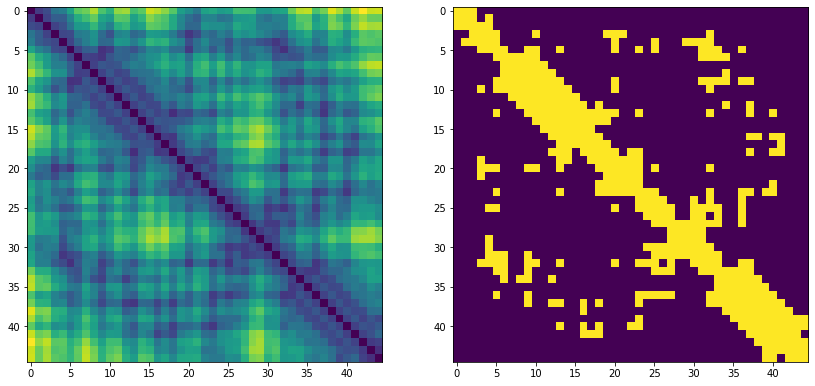

In [42]:
R = 8

_, axs = plt.subplots(1,2,figsize=(14,7))
axs[0].imshow(orig_matr)
axs[1].imshow(orig_matr < R)
plt.show()

# 2. Работа с потенциалом!

In [43]:
pot = Potential(read_pickle(p4)["sequence"], p1, p2, p4, init_angles_by_dists=False)

FileNotFoundError: [Errno 2] No such file or directory: './contacts_pdb1w4e_2020_07_22_14_31_46/torsion/0/torsions/1w4eA00.torsions'

## 2.1. Для начала посмотрим на значения потенциала AlphaFold для оригинальных данных:

Мы получили, что весь потенциал можно сделать зависимым от $\phi, \psi$. Подставим вектор оригинальных значений $\phi, \psi$ в потенциал:

In [44]:
pot.calc(orig_angles)

NameError: name 'pot' is not defined

Хорош ли этот результат? 🤔

Посмотрим отдельно значения составных частей потенциала:

- $V_{distance}$:

In [19]:
pot._calc_distance_potential(orig_angles)

NameError: name 'pot' is not defined

- $V_{torsion}$:

In [20]:
pot._calc_torsion_potential(orig_angles)

NameError: name 'pot' is not defined

$\uparrow$ Какой вывод можно сделать из такого результата?

**your ideas here**: TODO

## 2.2. Минимизируем!

Выберем начальные значения углов. Пусть это будут наиболее вероятные углы с точки зрения потенциала $V_{torsion}$:

In [40]:
x0 = pot.get_initial_angles()

In [49]:
x0

array([-1.22173048, -0.6981317 , -1.22173048, -0.6981317 , -1.22173048,
       -0.87266463, -1.22173048, -0.87266463, -1.22173048, -0.87266463,
       -1.22173048, -0.87266463, -1.22173048,  2.61799388, -1.3962634 ,
        2.7925268 , -1.22173048, -0.87266463, -1.22173048, -0.6981317 ,
       -1.22173048, -0.6981317 , -1.22173048, -0.87266463, -1.22173048,
       -0.87266463, -1.22173048, -0.87266463, -1.22173048, -0.87266463,
       -1.22173048, -0.6981317 , -1.22173048, -0.6981317 , -1.22173048,
       -0.87266463, -1.22173048, -0.6981317 , -1.22173048, -0.87266463,
       -1.22173048, -0.87266463, -1.22173048, -0.87266463, -1.22173048,
       -0.87266463, -1.22173048, -0.87266463, -1.22173048, -0.6981317 ,
       -1.22173048, -0.87266463, -1.22173048, -0.6981317 , -1.04719755,
       -0.87266463, -1.22173048, -0.6981317 , -1.04719755,  2.26892803,
       -1.04719755, -0.87266463, -1.22173048, -0.87266463, -1.22173048,
       -0.87266463, -1.22173048, -0.6981317 , -1.04719755, -0.87

**К слову**: а какое значение потенциала $V_{torsion}$ для $x_0$? 🤔

In [52]:
pot._calc_distance_potential(x0)

4.612518605830157

In [41]:
pot._calc_torsion_potential(x0)

307.82789998557877

In [53]:
pot.calc(x0)

312.4404185914089

Зададим множества значений переменных. Хорошо бы поставить границы $[\pi, \pi]$, но может, стоит как-то расширить диапазон? 🤔

In [42]:
bounds = [[-1.5 * np.pi, 1.5 * np.pi]] * len(x0)

In [55]:
bounds[:3]

[[-4.71238898038469, 4.71238898038469],
 [-4.71238898038469, 4.71238898038469],
 [-4.71238898038469, 4.71238898038469]]

Алгоритм минимизации - BFGS. Но оригинальный BFGS:

    - Не может обрабатывать ограничение множества значений переменных
    
    - Неэкономно расходует память
    
Поэтому возьмем модификацию BFGS - L-BFGS-B, которая предназначена для минимизации на ограниченных "брусах" в условиях ограниченной памяти:

In [43]:
method = "L-BFGS-B"

А еще мы можем попытаться "упростить жизнь" алгоритму за счет передачи ему функции, которая точно. вычисляет первую производную целевой функции в произвольной точке:

In [44]:
diff = pot.derivative

Уфф. Запускаем!

In [45]:
from time import time

In [47]:
print("minimization started")
st_time = time()

min_res = minimize(pot.calc, 
                   x0=x0,
                   bounds=bounds,
                   jac=diff,
                   method=method
                  )
print("minimization over. res = ", (min_res.success, min_res.message))
print(f"\tMinimization took {time() - st_time} sec")

minimization started
minimization over. res =  (False, 'ABNORMAL_TERMINATION_IN_LNSRCH')
	Minimization took 12.796360969543457 sec


In [56]:
min_res

      fun: 284.424963879021
 hess_inv: <90x90 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.52086891e+00,  1.64063934e+02, -2.04870416e-01, -6.12536493e+00,
       -6.19586994e+00,  1.49698369e+00, -3.13041139e+03, -2.43349973e+02,
        2.07335341e+00,  3.49704810e+00, -5.62727366e+00, -9.63280809e+00,
        4.77757710e-01, -3.40278813e-01, -1.23062498e+01,  4.17074441e+00,
       -5.56185170e+00, -1.38816337e+01, -1.11745192e+01,  2.56421843e+00,
       -5.74579315e+01,  1.16297239e+01, -1.67171271e-01,  4.82727044e+00,
       -1.27285027e+01, -1.83130518e+01, -4.22715014e-02,  6.75168406e+00,
       -7.41139073e+02,  2.57409082e+02, -3.12303462e+00, -6.57645167e+00,
        1.02086540e+01, -1.94035279e+01, -8.16904950e+00, -1.51746524e+01,
       -5.70705734e+00, -2.41465668e+00, -1.02157799e+00,  1.66540425e-02,
       -4.80553540e+00, -6.82462674e-01, -5.64648400e+01, -1.92809123e+01,
       -1.38461127e+03,  1.27155111e+00, -2.49739982e+03,  1.12733432e+02,
   

# 3. Оценим результат 🤔

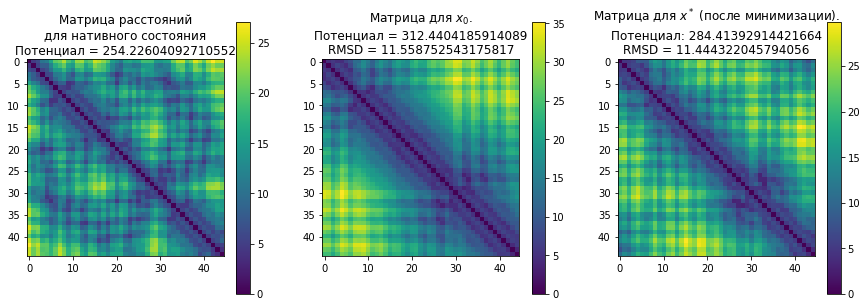

In [48]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
im = axs[0].imshow(orig_matr)
axs[0].set_title("Матрица расстояний\nдля нативного состояния\nПотенциал = {}".format(pot.calc(orig_angles)))
cbar = plt.colorbar(im, ax=axs[0])

imp = QCPSuperimposer()
imp.set(cbs, np.array(pot._model.get_cb_coords(pot.get_initial_angles()[1:-1])[0]))
imp.run()

im = axs[1].imshow(pot._model.get_cb_dist_matrix(pot.get_initial_angles()[1:-1]))
axs[1].set_title("Матрица для $x_0$.\nПотенциал = {}\nRMSD = {}".format(pot.calc(pot.get_initial_angles()), 
                                                                        imp.get_rms()))
plt.colorbar(im, ax=axs[1])

imp = QCPSuperimposer()
imp.set(cbs, np.array(pot._model.get_cb_coords(min_res.x[1:-1])[0]))
imp.run()

im = axs[2].imshow(pot._model.get_cb_dist_matrix(min_res.x[1:-1]))
axs[2].set_title("Матрица для $x^*$ (после минимизации).\nПотенциал: {}\nRMSD = {}".format(pot.calc(min_res.x), imp.get_rms()))
plt.colorbar(im, ax=axs[2])
# fig.suptitle("Белок 1h1j. Длина: {}".format(len(chain)))
plt.show()

$\uparrow$ Что получилось? Какие можно сделать выводы? 🤔

$\rightarrow$ **your ideas here**: TODO